# Transfer Learning

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

1. Load MobileNet (smaller ImageNet pre-trained CNN), without classifier
2. Train classifier with food pictures
3. Fine-tune the last layers and classifier

In [4]:
import matplotlib.pyplot as plt

# Image loading and augmentation
from keras.preprocessing.image import ImageDataGenerator

# Source network
from keras.applications import mobilenet

# Target network's classifier
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Dropout

# training
from keras.callbacks import TensorBoard, EarlyStopping
from keras.optimizers import SGD

# evaluation
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

# Data Preprocessing

ImageDataGenerator can be used for loading and augment images as a continuous stream.

Augmentation (add variety to training set to avoid overfitting):
-   rotation_range: randomly rotate image by some degrees
-   horizontal_flip: randomly flip image side to side

```
train_datagen = ImageDataGenerator(
    rotation_range=0.4,
    horizontal_flip=True,
    preprocessing_function=mobilenet.preprocess_input)

X_train_gen = train_datagen.flow_from_directory('data/train',
                                                target_size=(img_height, img_width),
                                                batch_size=n_train_set)
                                                
batch = next(X_train_gen)
```

In [12]:
img_height = img_width = 160
channels = 3

In [13]:
# Load the images
labels = ['chapati', 'fishball_noodle', 'satay']

train_folder = 'train'
n_train_set = 45

val_folder = 'validation'
n_val_set = 15

In [15]:
# preprocessing_function: use MobileNet's built-in function
#                    why: ensures similar input as training
#
# Augmentation (add variety to training set to avoid overfitting):
#   rotation_range: randomly rotate image by some degrees
#   horizontal_flip: randomly flip image side to side (roti prata flip)

from keras.applications import mobilenet

train_datagen = ImageDataGenerator(
    rotation_range=0.4,
    horizontal_flip=True,
    preprocessing_function=mobilenet.preprocess_input)

X_train_gen = train_datagen.flow_from_directory('data/train',
                                                target_size=(img_height, img_width),
                                                batch_size=n_train_set)

# conda install pillow
batch = next(X_train_gen)

Found 45 images belonging to 3 classes.


In [23]:
# batch.shape
#
# -------------------------------------------------------------------
#AttributeError                    Traceback (most recent call last)
#<ipython-input-23-09582364ff4f> in <module>
#----> 1 batch.shape

#AttributeError: 'tuple' object has no attribute 'shape'
#
# Because batch is a tuple like this:
# (images, labels)

AttributeError: 'tuple' object has no attribute 'shape'

In [24]:
len(batch) # number of elements in tuple

2

In [19]:
batch[0].shape # images

(45, 160, 160, 3)

In [20]:
batch[1].shape # labels

(45, 3)

In [28]:
batch[1][0] # first target - one hot encoding of 3 classes

array([0., 0., 1.], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


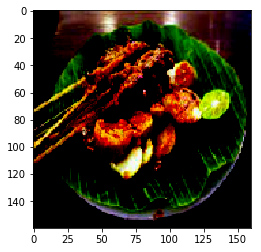

In [29]:
plt.imshow(batch[0][0]) # first input image

# Load Pre-trained Network

https://keras.io/applications/#mobilenet

In [34]:
model = mobilenet.MobileNet(input_shape=(img_height, img_width, channels),
                                         include_top=False) # exclude classifier
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 161, 161, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 80, 80, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 80, 80, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 80, 80, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 80, 80, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 80, 80, 32)        128       
__________

In [36]:
# Get predictions using training set.
# These are my input features into the classifier.

X_train = batch[0]
y_train = batch[1]
Z_train = model.predict(X_train)

In [37]:
Z_train.shape

(45, 5, 5, 1024)

In [38]:
5*5*1024

25600

# Train Classifier

- Flatten
- Dense layer (32 or 64)
- Dropout to avoid overfitting
- Dense (3)

Rules of thumbs: https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

In [82]:
from keras.layers import InputLayer

num_classes = 3
clf = Sequential()
clf.add(InputLayer(input_shape=(Z_train.shape[1:]))) # 5, 5, 1024
clf.add(Flatten())
clf.add(Dense(32, activation='relu'))
clf.add(Dense(num_classes, activation='softmax')) # multi-class use softmax,
                                                  # binary use sigmoid
clf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_15 (Flatten)         (None, 25600)             0         
_________________________________________________________________
dense_26 (Dense)             (None, 32)                819232    
_________________________________________________________________
dense_27 (Dense)             (None, 3)                 99        
Total params: 819,331
Trainable params: 819,331
Non-trainable params: 0
_________________________________________________________________


In [83]:
# setup optimisers, losses
clf.compile(optimizer='sgd', # can consider adam, etc
                             # if training is slow or want to improve
                             # accuracy (e.g. stuck in local minima)

            loss='categorical_crossentropy', # multi-class
                                             # binary: binary_crossentropy

            metrics=['accuracy']) # nice to see, otherwise you'll
                                  # just see the loss, val_loss
# setup callbacks
import time
tb = TensorBoard(log_dir='./logs/transfer_clf{}'.format(int(time.time())))

from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('transfer_clf.{epoch:02d}-{val_loss:.2f}.hdf5')

# fit
# batch_size = how much data to use for computing loss gradient for weight update
# Generally 64, 128 for most "medium sized" dataets
# For smaller datasets, try a factor of it (10% - 30%) first, or use the whole dataset
# if a factor is still too small
clf.fit(Z_train, y_train, batch_size=15, epochs=20,
        callbacks=[tb, mc], validation_split=0.2)

Train on 36 samples, validate on 9 samples
Epoch 1/20
36/36 [==============================] - 0s 11ms/step - loss: 6.7273 - acc: 0.2500 - val_loss: 8.9548 - val_acc: 0.4444
Epoch 2/20
36/36 [==============================] - 0s 1ms/step - loss: 3.5148 - acc: 0.6389 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 3/20
36/36 [==============================] - 0s 2ms/step - loss: 4.0674 - acc: 0.6389 - val_loss: 0.0457 - val_acc: 1.0000
Epoch 4/20
36/36 [==============================] - 0s 2ms/step - loss: 0.2155 - acc: 0.9444 - val_loss: 0.0530 - val_acc: 1.0000
Epoch 5/20
36/36 [==============================] - 0s 2ms/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.0477 - val_acc: 1.0000
Epoch 6/20
36/36 [==============================] - 0s 2ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0442 - val_acc: 1.0000
Epoch 7/20
36/36 [==============================] - 0s 2ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.0374 - val_acc: 1.0000
Epoch 8/20
36/36 [===========================

In [85]:
# Metrics

# get predictions
# 0. Load X_test
# 1. Transform X_test using MobileNet
# 2. Predict on Z_test using clf

test_datagen = ImageDataGenerator(
    preprocessing_function=mobilenet.preprocess_input)

X_test_gen = test_datagen.flow_from_directory('data/validation/',
                                             target_size=(img_height, img_width),
                                             batch_size=n_val_set)

batch_test = next(X_test_gen)

X_test = batch_test[0]
y_test = batch_test[1]

Z_test = model.predict(X_test)

pred = clf.predict_classes(Z_test)
pred

Found 15 images belonging to 3 classes.


array([0, 1, 0, 2, 1, 1, 2, 1, 2, 2, 1, 0, 0, 2, 0], dtype=int64)

In [89]:
y_test.argmax(axis=1) # collapses one-hot into categorical

array([0, 1, 0, 2, 1, 1, 2, 1, 2, 2, 1, 0, 0, 2, 0], dtype=int64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual satay predicted satay


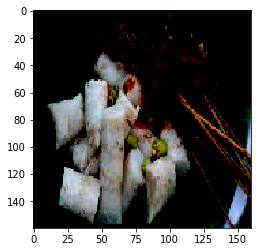

In [99]:
truth = y_test.argmax(axis=1)

index = 9
print('actual', labels[truth[index]], 'predicted', labels[pred[index]])
plt.imshow(X_test[index])

In [94]:
print(confusion_matrix(truth, pred))
print(classification_report(truth, pred))

[[5 0 0]
 [0 5 0]
 [0 0 5]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5

   micro avg       1.00      1.00      1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



# Fine-tune Classifier

```
featurizer = mobilenet.MobileNet(include_top=False,
                                 input_shape=(img_width, img_height, channels))

# Append the classifier we trained earlier to the featurizer
combined_model = Model(inputs=featurizer.input,
                       outputs=classifier(featurizer.output))

# Freeze layers up to the last 7th layer (non-inclusive)
for layer in combined_model.layers[:-7]:
    layer.trainable = False # freeze

combined_model.summary()
```

In [100]:
featurizer = mobilenet.MobileNet(include_top=False,
                                 input_shape=(img_width, img_height, channels))

# Append the classifier we trained earlier to the featurizer
#
# This uses Kera's functional API (Model) to setup the model:
#   Model's input is featurizer's input
#   Classifier's input is featurizer's output
#   Model's output is classifier's output
#
combined_model = Model(inputs=featurizer.input,
                       outputs=clf(featurizer.output))

# Freeze layers up to the last 7th layer (non-inclusive)
for layer in combined_model.layers[:-7]:
    layer.trainable = False # freeze

combined_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 160, 160, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 161, 161, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 80, 80, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 80, 80, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 80, 80, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 80, 80, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 80, 80, 32)        128       
__________

In [105]:
# compile
from keras.optimizers import SGD

# customise sgd with very small learning rate
# fine-tuning is about slowly adjusting the weights
# so learning rate should be small (limit changes)
sgd = SGD(lr=1e-3) # or try 1e-4
combined_model.compile(optimizer=sgd,
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# callbacks
tb = TensorBoard(log_dir='./logs/transfer_ft/{}'.format(int(time.time())))
es = EarlyStopping(patience=1)
mc = ModelCheckpoint('transfer_ft.{epoch:02d}-{val_loss:.2f}.hdf5')

# fit
combined_model.fit(X_train, y_train, batch_size=15, epochs=20,
        callbacks=[tb, es, mc], validation_split=0.2)

Train on 36 samples, validate on 9 samples
Epoch 1/20
36/36 [==============================] - 8s 216ms/step - loss: 0.0223 - acc: 1.0000 - val_loss: 0.0412 - val_acc: 1.0000
Epoch 2/20
36/36 [==============================] - 5s 146ms/step - loss: 0.0602 - acc: 0.9722 - val_loss: 0.0239 - val_acc: 1.0000
Epoch 3/20
36/36 [==============================] - 5s 146ms/step - loss: 0.0074 - acc: 1.0000 - val_loss: 0.0234 - val_acc: 1.0000
Epoch 4/20
36/36 [==============================] - 5s 146ms/step - loss: 0.0172 - acc: 1.0000 - val_loss: 0.0222 - val_acc: 1.0000
Epoch 5/20
36/36 [==============================] - 6s 156ms/step - loss: 0.0085 - acc: 1.0000 - val_loss: 0.0222 - val_acc: 1.0000


In [114]:
# Predictions

# feed the images directly to the combined model
# without transforming through the featuriser
# (because the featuriser is part of combined_model
# and it is already fine-tuned)
pred = combined_model.predict(X_test)

# convert from probabilities to labels
pred_labels = pred.argmax(axis=1) 

In [115]:
print(classification_report(truth, pred_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5

   micro avg       1.00      1.00      1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



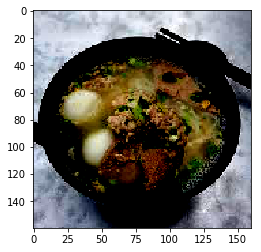

In [107]:
# for getting rid of the warning
import numpy as np
plt.imshow(np.clip(batch_test[0][1], 0, 1))